In [2]:
from nltk.corpus import stopwords

import nltk
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/mini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv('sqli.csv', encoding='utf-16')

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    min_df=2,
    max_df=0.7,
    max_features=4096,
    stop_words=stopwords.words('english')
)
X = vectorizer.fit_transform(df['Sentence'].values.astype('U')).toarray()

In [6]:
X.shape

(4200, 4096)

In [7]:
X = X.reshape(X.shape[0], 64, 64, 1)

In [8]:
X.shape

(4200, 64, 64, 1)

In [9]:

y=df['Label']

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
trainX = X_train.copy()
trainX.shape=(X_train.shape[0],trainX.shape[1]*trainX.shape[2])
testX=X_test.copy()
testX.shape=(testX.shape[0],testX.shape[1]*testX.shape[2])

In [9]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
gnb.fit(trainX, y_train)
pred_gnb = gnb.predict(testX)

In [10]:
#SVM
from sklearn.svm import SVC


clf = SVC(gamma='auto')
clf.fit(trainX, y_train)
pred_svm=clf.predict(testX)

In [11]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

neigh=KNeighborsClassifier(n_neighbors=3)
neigh.fit(trainX,y_train)
pred_knn=neigh.predict(testX)

In [12]:
#DTree
from sklearn import tree


dt=tree.DecisionTreeClassifier()
dt=dt.fit(trainX, y_train)
pred_dt=dt.predict(testX)

In [11]:
#CNN
import tensorflow as tf


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128,(3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
fla

In [13]:
classifier_nn=model.fit(X_train,y_train,
                        epochs=10,
                        validation_data=(X_test, y_test),
                        batch_size=128)

Train on 3360 samples, validate on 840 samples
Epoch 1/10
3360/3360 [==============================]3360/3360 [==============================] - 71s 21ms/step - loss: 0.3062 - acc: 0.8494 - val_loss: 0.1884 - val_acc: 0.9214

Epoch 2/10
3360/3360 [==============================]3360/3360 [==============================] - 50s 15ms/step - loss: 0.1440 - acc: 0.9387 - val_loss: 0.1445 - val_acc: 0.9417

Epoch 3/10
3360/3360 [==============================]3360/3360 [==============================] - 54s 16ms/step - loss: 0.1112 - acc: 0.9536 - val_loss: 0.1223 - val_acc: 0.9440

Epoch 4/10
3360/3360 [==============================]3360/3360 [==============================] - 60s 18ms/step - loss: 0.0933 - acc: 0.9577 - val_loss: 0.1168 - val_acc: 0.9512

Epoch 5/10
3360/3360 [==============================]3360/3360 [==============================] - 54s 16ms/step - loss: 0.0840 - acc: 0.9643 - val_loss: 0.1030 - val_acc: 0.9560

Epoch 6/10
3360/3360 [==============================]3360/

In [14]:
pred_nn = model.predict(X_test)

for i in range(len(pred_nn)):
    if pred_nn[i]>0.5:
        pred_nn[i]=1
    elif pred_nn[i]<=0.5:
        pred_nn[i]=0


In [17]:
"""from sklearn.metrics import accuracy_score


accuracy_score(y_test,pred_nn)"""

0.9654761904761905

In [15]:
#save the model
from keras.models import load_model
import pickle


model.save('model_cnn_3.h5')
with open('vectorizer_cnn','wb') as fin:
    pickle.dump(vectorizer, fin)

Using TensorFlow backend.


In [19]:
"""#confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score


accuracy, precision, recall = accuracy_score(y_test, pred_nn),\
    precision_score(y_test, pred_nn),\
    recall_score(y_test, pred_nn)

print(f"For CNN\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")

accuracy, precision, recall = accuracy_score(y_test, pred_gnb),\
    precision_score(y_test, pred_gnb),\
    recall_score(y_test, pred_gnb)

print(f"For Naive Bayes\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")

accuracy, precision, recall = accuracy_score(y_test, pred_svm), \
    precision_score(y_test, pred_svm), \
    recall_score(y_test, pred_svm)
print(f"For SVM\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")

accuracy, precision, recall = accuracy_score(y_test, pred_knn), \
    precision_score(y_test, pred_knn), \
    recall_score(y_test, pred_knn)
print(f"For KNN\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")

accuracy, precision, recall = accuracy_score(y_test, pred_dt), \
    precision_score(y_test, pred_dt), \
    recall_score(y_test, pred_dt)
print(f"For Decision Tree\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")
"""
#comments on the obtained results
'''
Naive Bayes performed well in terms of accuracy, precision, and recall, achieving high values in all metrics.

SVM achieved perfect precision but relatively low accuracy and recall.

CNN showed high accuracy and recall, but its precision was slightly lower than Naive Bayes.

KNN had relatively lower accuracy, precision, and recall compared to the other methods.

Decision Tree performed reasonably well with good accuracy and precision, but its recall was perfect.'''

For CNN
Accuracy: 0.9654761904761905
Precision: 0.9114391143911439
Recall: 0.9801587301587301
For Naive Bayes
Accuracy: 0.9773809523809524
Precision: 0.9298892988929889
Recall: 1.0
For SVM
Accuracy: 0.7642857142857142
Precision: 1.0
Recall: 0.21428571428571427
For KNN
Accuracy: 0.5976190476190476
Precision: 0.4271186440677966
Recall: 1.0
For Decision Tree
Accuracy: 0.8702380952380953
Precision: 0.6980609418282548
Recall: 1.0


'\nNaive Bayes performed well in terms of accuracy, precision, and recall, achieving high values in all metrics.\n\nSVM achieved perfect precision but relatively low accuracy and recall.\n\nCNN showed high accuracy and recall, but its precision was slightly lower than Naive Bayes.\n\nKNN had relatively lower accuracy, precision, and recall compared to the other methods.\n\nDecision Tree performed reasonably well with good accuracy and precision, but its recall was perfect.'

27/27 [==============================] - 1s 48ms/step


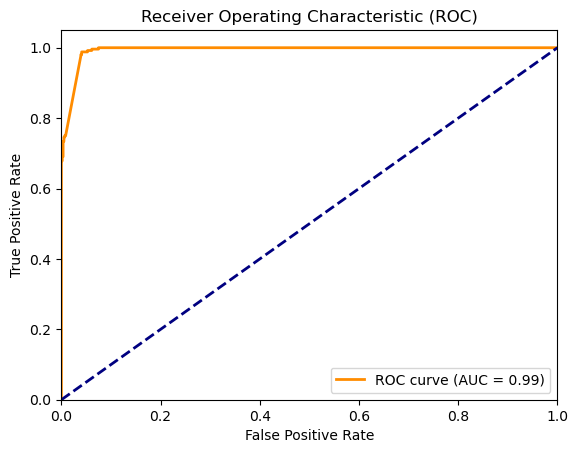

In [20]:
"""from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()"""